In [9]:
"""Set of functions for the integration of dynamical systems described by ODE (compiled with numba)"""

from numba import jit_module
import numpy as np
import matplotlib.pyplot as plt
import time

### Integrator functions

In [10]:
# y' = f(x,t)

#-------------------EULER INTEGRATOR----------------------#
# y_n+1 = y_n + h * y'_n + O(h^2)

def euler(f, x, t, p = ()):
    """
    Simple Euler integrator.
    
    Parameters
    ----------
    f: function
        the function to integrate: f(x, t, p=()). 
        The first argument is the real value(s) at this step, 
        the second is the time at this step, the third are a
        tuple of parameters of the system.
    x: numpy nd-array
        Array containing in the first position the initial 
        condition.
    t: numpy nd-array
        Array of the same lenght of x containing the time steps
        in wich the system will be evaluated.
    p: tuple
        Tuple of parameters of the function f.
        
    Result
    ------
    numpy nd-array
        Array x containing the results of the integration at 
        each time steps of t.
    """
    
    # Saving starting time
    tj = t[0]
    # Saving h value
    h = t[1]-tj
    # Number of step
    step = len(t)
    # Saving initial value
    xj = x[0]
    for j in range(1, step):
        # Evaluate next step
        xj = xj + h * f(xj, tj, p)
        # Saving next step value
        x[j] = xj
        # Go to the next time step
        tj = tj + h
    return x

#-------------------TRAPEIZODAL INTEGRATOR----------------------#
# y_n+1 = y_n + h/2 (y'_n + y'_n+1) + O(h^3)

def trapezoid(f, x, t, p = ()):
    """
    Trapezoid integration method.
    
    Parameters
    ----------
    f: function
        the function to integrate: f(x, t, p=()). 
        The first argument is the real value(s) at this step, 
        the second is the time at this step, the third are a
        tuple of parameters of the system.
    x: numpy nd-array
        Array containing in the first position the initial 
        condition.
    t: numpy nd-array
        Array of the same lenght of x containing the time steps
        in wich the system will be evaluated.
    p: tuple
        Tuple of parameters of the function f.
        
    Result
    ------
    numpy nd-array
        Array x containing the results of the integration at 
        each time steps of t.
    """
    
    tj = t[0]
    tjn = t[1]
    h = tjn-tj
    step = len(t)
    xj = x[0]
    for j in range(1, step):
        # function evaluated in xj (y'_n)
        fj = f( xj, tj , p )
        # euler step (y_n+1 euler)
        xjn = xj + h * fj
        # function evaluated in the euler step (y'_n+1 euler)
        fjn = f( xjn, tjn , p)

        # Trapezoid evaluation of the next point obtained with the euler step (y_n+1 trap)
        xjn = xj + h/2 * ( fj + fjn )
        # Evaluation of the force in the next step (y'_n+1 trap)
        fjn = f( xjn, tjn , p )

        # Final evaluation of the next point with the force evaluated with euler -> trapezoid
        xj = xj + h/2 * ( fj + fjn )
        # Saving result and go to next step
        x[j] = xj
        tj = tj + h
        tjn = tjn + h
    return x

#-----------------------AB INTEGRATOR-------------------------#
#y_n+1 = y_n + h(3y'_n - y'_n-1)/2 + O(h^3) 

def AB(f, x, t, p = ()):
    """
    AB integration method.
    
    Parameters
    ----------
    f: function
        the function to integrate: f(x, t, p=()). 
        The first argument is the real value(s) at this step, 
        the second is the time at this step, the third are a
        tuple of parameters of the system.
    x: numpy nd-array
        Array containing in the first position the initial 
        condition.
    t: numpy nd-array
        Array of the same lenght of x containing the time steps
        in wich the system will be evaluated.
    p: tuple
        Tuple of parameters of the function f.
        
    Result
    ------
    numpy nd-array
        Array x containing the results of the integration at 
        each time steps of t.
    """
    # Starting time
    tj = t[0]
    # Integration step
    h = t[1]-tj
    # Number of step
    step = len(t)
    # Starting Point
    xj = x[0]
    
    # Evaluate the function in the starting point
    f_here = f(xj, tj, p)
    # Euler step
    xj = xj + h * f_here
    # Go to the next time step
    tj = tj + h
    # Next point
    x[1] = xj
    # Save the value of f for the next step
    f_back = f_here
    for j in range(1, step-1):
        # Evaluate the function at this step
        f_here = f(xj, tj, p)
        # Evaluate new point
        xj = xj + h/2 * (3 * f_here - f_back)
        # Write the new point
        x[j+1] = xj
        # Save the old function
        f_back = f_here
        # Increase time step
        tj = tj + h
    return x

#-------------------MIDPOINT INTEGRATOR----------------------#
# y_n+1 = y_n-1 + 2h * y'_n + O(h^3)

def midpoint(f, x, t, p = ()):
    """
    Midpoint integration method.
    
    Parameters
    ----------
    f: function
        the function to integrate: f(x, t, p=()). 
        The first argument is the real value(s) at this step, 
        the second is the time at this step, the third are a
        tuple of parameters of the system.
    x: numpy nd-array
        Array containing in the first position the initial 
        condition.
    t: numpy nd-array
        Array of the same lenght of x containing the time steps
        in wich the system will be evaluated.
    p: tuple
        Tuple of parameters of the function f.
        
    Result
    ------
    numpy nd-array
        Array x containing the results of the integration at 
        each time steps of t.
    """
    # Save initial time
    tj = t[0]
    # Save time step
    h = t[1]-tj
    # Number of step
    step = len(t)
    # Save initial value as xjprevious
    xjp = x[0]
    # New point
    xj = xjp + h * f(xjp, tj, p)
    # Save new point
    x[1] = xj
    # New time
    tj = tj + h
    for j in range(2, step):
        # Next point as combination of last two
        xn = xjp + 2 * h * f(xj, tj, p)
        # Save new point
        x[j] = xn
        # The actual became the previus
        xjp = xj
        # The next became the actual
        xj = xn
        # Next time step
        tj = tj + h
    return x

#-------------------RUNGE-KUTTA INTEGRATOR----------------------#

def RK45(f, x, t, p = ()):
    """
    Runge Kutta (of order 4-5) integration method.
    
    Parameters
    ----------
    f: function
        the function to integrate: f(x, t, p=()). 
        The first argument is the real value(s) at this step, 
        the second is the time at this step, the third are a
        tuple of parameters of the system.
    x: numpy nd-array
        Array containing in the first position the initial 
        condition.
    t: numpy nd-array
        Array of the same lenght of x containing the time steps
        in wich the system will be evaluated.
    p: tuple
        Tuple of parameters of the function f.
        
    Result
    ------
    numpy nd-array
        Array x containing the results of the integration at 
        each time steps of t.
    """
    # Initial time
    tj = t[0]
    # Integral step
    h = t[1]-tj
    # Number of step
    step = len(t)
    # Save Initial value
    xj = x[0]
    for j in range(1, step):
        k1 = h * f( xj , tj , p )
        k2 = h * f( xj + k1 / 2 , tj + h / 2 , p)
        k3 = h * f( xj + k2 / 2 , tj + h / 2 , p)
        k4 = h * f( tj + h , xj + k3 , p)
        xj = xj + k1/6 + k2/3 + k3 / 3 + k4 / 6
        x[j] = xj
        tj = tj + h
    return x

### Comparison

Num of teration: 21

Euler: 0.000s
Trapezoidal: 0.000s
AB: 0.000s
midpoint: 0.000s
RK45: 0.000s


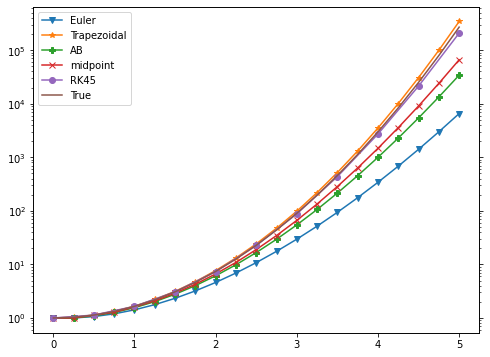

In [39]:
@njit
def wake_up_numba():
    return None

@njit(cache=True)
def f(x, t, p = ()):
    return x * t

def test_int():
    wake_up_numba()

    real_benchmark = True
    plot = True
    x0 = 1
    ti = 0
    tf = 5
    h = 0.25

    t = np.arange(ti, tf + h, h)
    print('Num of teration:', len(t))
    x = np.empty( len(t) )
    x[0] = x0

    to_test = [euler, 
               trapezoid, 
               AB, 
               midpoint, 
               RK45]

    if real_benchmark:
        for method in to_test:
            method(f , np.copy(x) , t)
    
    tt = []
    xx = []
    for method in to_test:
        if method == RK45:
            y = np.copy(x[::2])
            tRK = t[::2]
            start = time.time()
            xx.append(method( f , y , tRK ))
            tt.append(time.time()-start)
        else:
            y = np.copy(x)
            start = time.time()
            xx.append(method( f , y , t ))
            tt.append(time.time()-start)
            
    x_eu, x_trap, x_AB, x_mid, x_RK = xx
    t_eu, t_trap, t_AB, t_mid, t_RK = tt

    if real_benchmark:
        print()
        print(f'Euler: {t_eu:.3f}s')
        print(f'Trapezoidal: {t_trap:.3f}s')
        print(f'AB: {t_AB:.3f}s')
        print(f'midpoint: {t_mid:.3f}s')
        print(f'RK45: {t_RK:.3f}s')

    if plot:
        fig, ax = plt.subplots(1,1,figsize=(8, 6))
        ax.plot( t,  x_eu   , marker='v', label = f'Euler')
        ax.plot( t,  x_trap , marker='*', label = f'Trapezoidal')
        ax.plot( t,  x_AB   , marker='P', label = f'AB')
        ax.plot( t,  x_mid  , marker='x', label = f'midpoint')
        ax.plot( tRK,  x_RK  , marker='o' , label = f'RK45')
        ax.plot(t, np.exp(t**2/2), label = 'True')

        ax.set_yscale('log')
        plt.legend()
        ax1 = ax.twinx()
        ax1.set_yscale('log')
        ax1.set_ylim(ax.get_ylim())
        ax1.tick_params(labelright=False)
        #plt.savefig('../Figures/IntegratorPrecision.png', dpi = 100)
        plt.show()

if __name__=='__main__':
    test_int()

### Step control : precision by Richardson

In [36]:
def richardson_error(f, x, t, method = 'RK45', p=()):
    """
    Evaluate the richardson error for the integrator of
    this module.
    NOTE: not sure that this function do something with any sense...
    
    Parameters
    ----------
    f: function
        the function to integrate: f(x, t, p=()). 
        The first argument is the real value(s) at this step, 
        the second is the time at this step, the third are a
        tuple of parameters of the system.
    x: numpy nd-array
        Array containing in the first position the initial 
        condition.
    t: numpy nd-array
        Array of the same lenght of x containing the time steps
        in wich the system will be evaluated.
    method: string
        A string containing the name of the integration method
        for wich the Richardson error will be evaluated.
        The option are: 'RK45' (default), 'euler', 'midpoint',
        'trapezoid', 'AB'.
    p: tuple
        Tuple of parameters of the function f.
        
    Result
    ------
    numpy nd-array
        Array containing the error evaluated every two time 
        steps of t (so the lenght of the array is the half of x)
    """
    
    # Saving starting time
    #tj = t[0]
    # Saving h value
    #h = t[1]-tj
    
    #h2 = 2*h
    #t2 = t = np.arange(t[0], t[-1], h2)
    
    half_len = int(len(t)/2)
    t2 = t[:half_len] * 2

    if method == 'RK45':
        x_2t = RK45(f, x, t2, p)
        x_t = RK45(f, x, t, p)
        frac = 15
    if method == 'euler':
        x_2t = euler(f, x, t2, p)
        x_t = euler(f, x, t, p)
        frac = 1
    if method == 'trapezoid':
        x_2t = trapezoid(f, x, t2, p)
        x_t = trapezoid(f, x, t, p)
        frac = 3
    if method == 'midpoint':
        x_2t = midpoint(f, x, t2, p)
        x_t = midpoint(f, x, t, p)
        frac = 3
    if method == 'AB':
        x_2t = AB(f, x, t2, p)
        x_t = AB(f, x, t, p)
        frac = 3

    x_2t = x_2t[:half_len]
    x_t = x_t[::2]

    return np.abs(x_t - x_2t)/frac


#jit_module(fastmath = True, nopython=True, cache = True)

Num of teration: 200


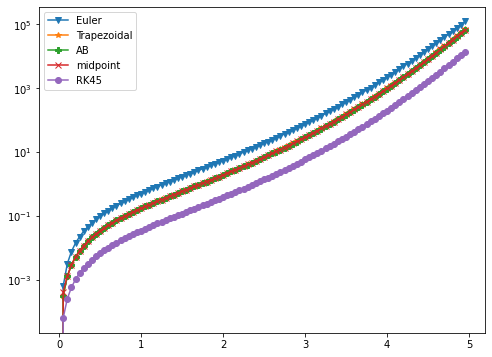

In [37]:
#import integrators
from numba import njit
import numpy as np
import matplotlib.pyplot as plt

@njit(cache=True)
def f(x, t, p = ()):
    return x * t

def test_int():
    x0 = 1
    ti = 0
    tf = 5
    h = 0.025

    t = np.arange(ti, tf, h)
    print('Num of teration:', len(t))
    x = np.empty( len(t) )
    x[0] = x0


    e_eu   = richardson_error( f , np.copy(x) , t , method = 'euler')
    e_trap = richardson_error( f , np.copy(x) , t , method = 'trapezoid')
    e_AB   = richardson_error( f , np.copy(x) , t , method = 'AB')
    e_mid  = richardson_error( f , np.copy(x) , t , method = 'midpoint')
    e_RK   = richardson_error( f , np.copy(x) , t , method = 'RK45')

    fig, ax = plt.subplots(1,1,figsize=(8, 6))
    ax.plot( t[::2],  e_eu   , marker='v', label = f'Euler')
    ax.plot( t[::2],  e_trap , marker='*', label = f'Trapezoidal')
    ax.plot( t[::2],  e_AB   , marker='P', label = f'AB')
    ax.plot( t[::2],  e_mid  , marker='x', label = f'midpoint')
    ax.plot( t[::2],  e_RK  , marker='o', label = f'RK45')

    ax.set_yscale('log')
    plt.legend()
    #plt.savefig('../Figures/IntegratorError.png', dpi = 100)
    plt.show()

if __name__=='__main__':
    test_int()
    
    